In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [2]:
import pandas as pd
import numpy as np
from bayesian.train_bn import structure_learning, parameter_learning, parameter_learning_mix
from preprocess.discretization import get_nodes_type, discretization, inverse_discretization, code_categories
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN
from bayesian.calculate_accuracy import calculate_acc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from copy import copy
from external.libpgm.sampleaggregator import SampleAggregator
import operator
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy import stats
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
import math
from pomegranate import DiscreteDistribution
import random
from sklearn.model_selection import train_test_split

In [3]:
df_result_accuracy = pd.DataFrame(columns = ['Parameter', 'Strategy', 'Alg', 'accuracy'])
df_result_rmse = pd.DataFrame(columns = ['Parameter', 'Strategy', 'Alg', 'rmse'])

In [4]:
geo = pd.read_csv('../datasets/sangiovese.csv')
geo = geo.drop(columns=['Unnamed: 0'])
columns = ['Treatment', 'SproutN', 'BunchN', 'GrapeW', 'WoodW',
       'SPAD06', 'NDVI06', 'SPAD08', 'NDVI08', 'Acid', 'Potass', 'Brix', 'pH',
       'Anthoc', 'Polyph']
geo = geo[columns]
geo.dropna(inplace=True)
geo.reset_index(inplace=True, drop=True)

In [5]:
geo_train, geo_test = train_test_split(geo, test_size=0.1)
geo_train.reset_index(inplace=True, drop=True)
geo_test.reset_index(inplace=True, drop=True)

In [6]:
geo_types = get_nodes_type(geo)
geo_types

{'Treatment': 'disc',
 'SproutN': 'cont',
 'BunchN': 'cont',
 'GrapeW': 'cont',
 'WoodW': 'cont',
 'SPAD06': 'cont',
 'NDVI06': 'cont',
 'SPAD08': 'cont',
 'NDVI08': 'cont',
 'Acid': 'cont',
 'Potass': 'cont',
 'Brix': 'cont',
 'pH': 'cont',
 'Anthoc': 'cont',
 'Polyph': 'cont'}

In [7]:
colums_for_code = []
columns_for_disc = []
for c in columns:
    if geo_types[c] == 'disc':
        colums_for_code.append(c)
    else:
        columns_for_disc.append(c)

In [8]:
geo_coded, label_coder = code_categories(geo_train, 'label', colums_for_code)
geo_discrete, coder = discretization(geo_coded, 'equal_frequency', columns_for_disc)
geo_only_discrete, discrete_coder = discretization(geo_train, 'equal_frequency', columns_for_disc)

# Hill Climbing

# Дискретная структра + смешанные параметры

In [9]:
bn_geo = structure_learning(geo_discrete, 'HC', 'MI', geo_types)

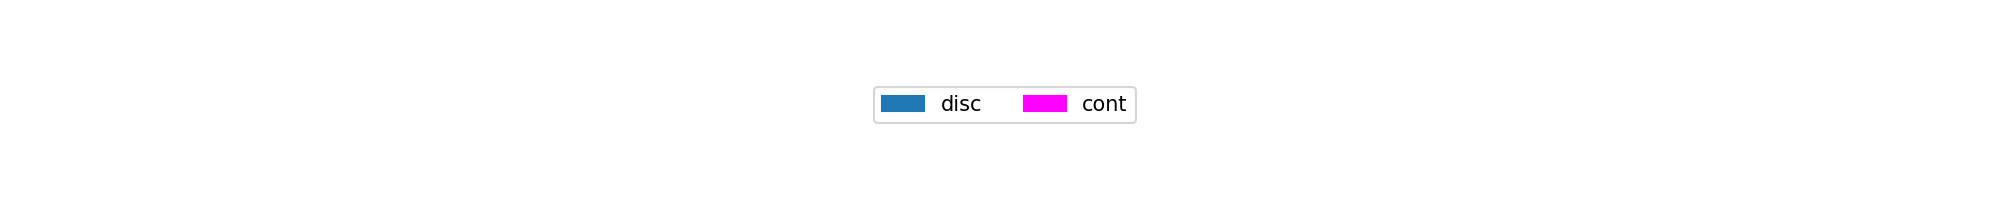

In [10]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [11]:
params = parameter_learning(geo_train, geo_types, bn_geo)

In [12]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [13]:
acc, rmse, real_data, pred_data = calculate_acc(geo_bn, geo_test, columns)

In [14]:
acc

{'Treatment': 0.06}

In [15]:
rmse

{'SproutN': 0.27,
 'BunchN': 0.52,
 'GrapeW': 0.72,
 'WoodW': 0.54,
 'SPAD06': 0.14,
 'NDVI06': 0.14,
 'SPAD08': 0.16,
 'NDVI08': 0.17,
 'Acid': 0.2,
 'Potass': 0.2,
 'Brix': 0.1,
 'pH': 0.05,
 'Anthoc': 0.49,
 'Polyph': 0.34}

In [16]:
for key in acc.keys():
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'HC', 'Alg':'D+M','accuracy':acc[key]}, ignore_index=True)
for key in rmse.keys():
    df_result_rmse = df_result_rmse.append({'Parameter': key, 'Strategy': 'HC', 'Alg':'D+M','rmse':rmse[key]}, ignore_index=True)

# Смешанная структура + смешанные параметры

In [17]:
bn_geo = structure_learning(geo_coded, 'HC', 'MI', geo_types)

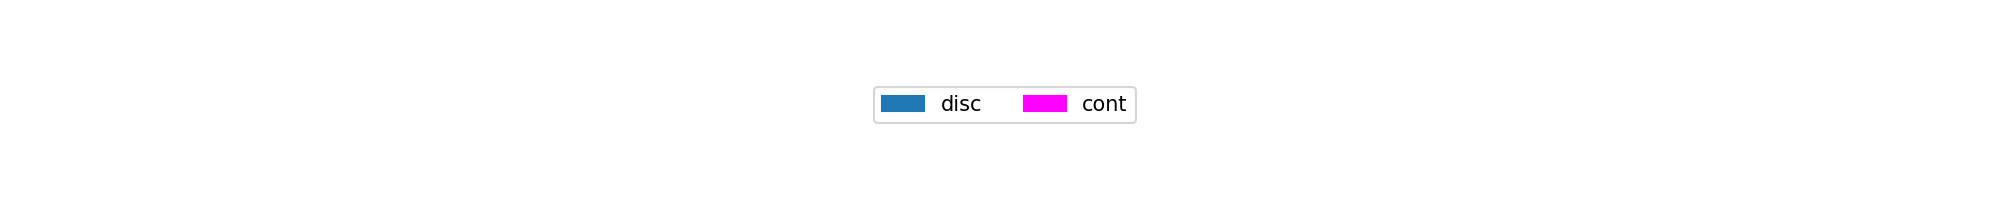

In [18]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [19]:
params = parameter_learning(geo_train, geo_types, bn_geo)

In [20]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [21]:
acc, rmse, real, pred = calculate_acc(geo_bn, geo_test, columns)

In [22]:
acc

{'Treatment': 0.06}

In [23]:
rmse

{'SproutN': 0.25,
 'BunchN': 0.52,
 'GrapeW': 0.59,
 'WoodW': 0.49,
 'SPAD06': 0.13,
 'NDVI06': 0.13,
 'SPAD08': 0.14,
 'NDVI08': 0.16,
 'Acid': 0.19,
 'Potass': 0.2,
 'Brix': 0.1,
 'pH': 0.05,
 'Anthoc': 0.48,
 'Polyph': 0.33}

In [24]:
for key in acc.keys():
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'HC', 'Alg':'M+M','accuracy':acc[key]}, ignore_index=True)
for key in rmse.keys():
    df_result_rmse = df_result_rmse.append({'Parameter': key, 'Strategy': 'HC', 'Alg':'M+M','rmse':rmse[key]}, ignore_index=True)

# Дискретная стурктура + дискретные параметры

In [25]:
geo_new_types = {'Treatment': 'disc',
 'SproutN': 'disc',
 'BunchN': 'disc',
 'GrapeW': 'disc',
 'WoodW': 'disc',
 'SPAD06': 'disc',
 'NDVI06': 'disc',
 'SPAD08': 'disc',
 'NDVI08': 'disc',
 'Acid': 'disc',
 'Potass': 'disc',
 'Brix': 'disc',
 'pH': 'disc',
 'Anthoc': 'disc',
 'Polyph': 'disc'}

In [26]:
bn_geo = structure_learning(geo_discrete, 'HC', 'MI', geo_new_types)

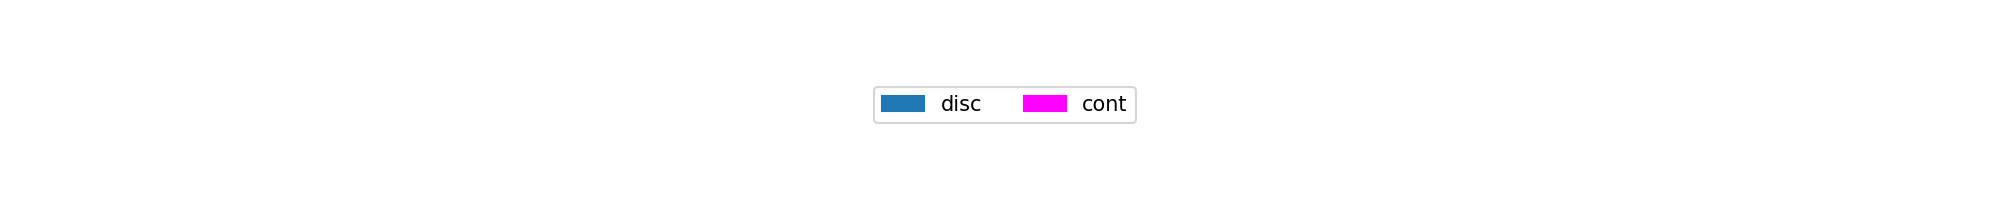

In [27]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [28]:
params = parameter_learning(geo_only_discrete, geo_new_types, bn_geo)

In [29]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [30]:
test_discrete = copy(geo_test)

In [31]:
test_discrete[columns_for_disc] = discrete_coder.transform(geo_test[columns_for_disc].values) 

In [32]:
for c in columns_for_disc:
    test_discrete[c] = test_discrete[c].apply(lambda x: int(x))
test_discrete

,Treatment,SproutN,BunchN,GrapeW,WoodW,SPAD06,NDVI06,SPAD08,NDVI08,Acid,Potass,Brix,pH,Anthoc,Polyph
0,T6b,1,0,1,1,0,2,1,1,3,0,0,0,3,2
1,T3a,0,1,0,1,0,1,0,1,1,3,4,2,4,3
2,T7a,4,0,0,1,1,0,1,2,2,3,1,2,3,2
3,T3a,1,1,3,3,4,3,3,2,0,3,1,3,2,1
4,T3a,0,2,3,1,0,2,3,2,2,0,0,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,T5a,1,1,2,1,1,4,2,2,4,0,0,0,0,1
296,T1a,1,2,4,2,3,4,4,3,1,4,0,3,0,0
297,T3a,3,4,3,1,3,1,1,4,2,2,0,2,0,2
298,T8b,4,2,2,3,2,1,2,3,3,3,2,3,1,2


In [33]:
acc, rmse, real, pred = calculate_acc(geo_bn, test_discrete, columns)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future wil

In [34]:
acc

{'Treatment': 0.06,
 'SproutN': 0.0,
 'BunchN': 0.0,
 'GrapeW': 0.0,
 'WoodW': 0.0,
 'SPAD06': 0.0,
 'NDVI06': 0.0,
 'SPAD08': 0.0,
 'NDVI08': 0.0,
 'Acid': 0.0,
 'Potass': 0.0,
 'Brix': 0.0,
 'pH': 0.0,
 'Anthoc': 0.0,
 'Polyph': 0.0}

In [35]:
for key in colums_for_code:
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'HC', 'Alg':'D+D','accuracy':acc[key]}, ignore_index=True)

In [36]:
invers_real = inverse_discretization(pd.DataFrame(np.transpose(real[1:15]), columns=['SproutN', 'BunchN', 'GrapeW', 'WoodW',
       'SPAD06', 'NDVI06', 'SPAD08', 'NDVI08', 'Acid', 'Potass', 'Brix', 'pH',
       'Anthoc', 'Polyph']), ['SproutN', 'BunchN', 'GrapeW', 'WoodW',
       'SPAD06', 'NDVI06', 'SPAD08', 'NDVI08', 'Acid', 'Potass', 'Brix', 'pH',
       'Anthoc', 'Polyph'], discrete_coder)

In [37]:
invers_pred = inverse_discretization(pd.DataFrame(np.transpose(pred[1:15]), columns=['SproutN', 'BunchN', 'GrapeW', 'WoodW',
       'SPAD06', 'NDVI06', 'SPAD08', 'NDVI08', 'Acid', 'Potass', 'Brix', 'pH',
       'Anthoc', 'Polyph']), ['SproutN', 'BunchN', 'GrapeW', 'WoodW',
       'SPAD06', 'NDVI06', 'SPAD08', 'NDVI08', 'Acid', 'Potass', 'Brix', 'pH',
       'Anthoc', 'Polyph'], discrete_coder)

In [38]:
for c in ['SproutN', 'BunchN', 'GrapeW', 'WoodW',
       'SPAD06', 'NDVI06', 'SPAD08', 'NDVI08', 'Acid', 'Potass', 'Brix', 'pH',
       'Anthoc', 'Polyph']:
    m = mean_squared_error(invers_real[c], invers_pred[c], squared=False)
    df_result_rmse = df_result_rmse.append({'Parameter': c, 'Strategy': 'HC', 'Alg':'D+D','rmse':m}, ignore_index=True)

# Смешанная структура + дискретные параметры

In [39]:
bn_geo = structure_learning(geo_coded, 'HC', 'MI', geo_new_types)

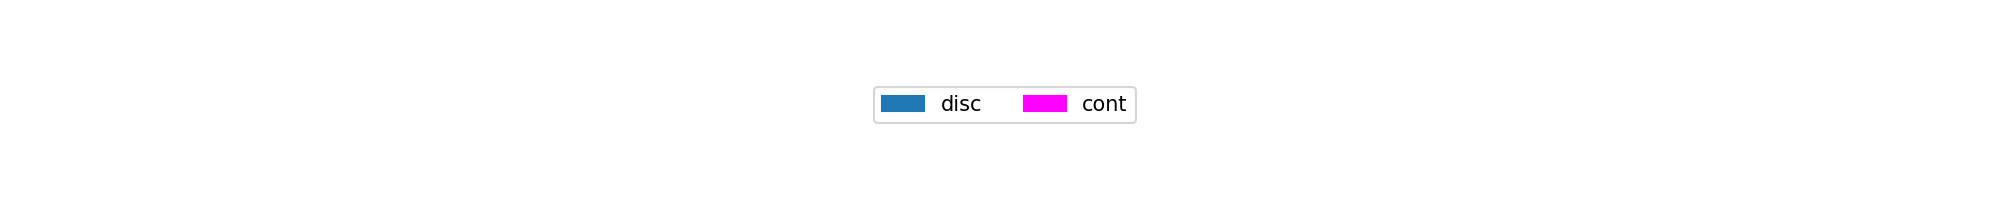

In [40]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [41]:
params = parameter_learning(geo_only_discrete, geo_new_types, bn_geo)

In [42]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [43]:
acc, rmse, real, pred = calculate_acc(geo_bn, test_discrete, columns)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future wil

In [44]:
acc

{'Treatment': 0.07,
 'SproutN': 0.0,
 'BunchN': 0.0,
 'GrapeW': 0.0,
 'WoodW': 0.0,
 'SPAD06': 0.0,
 'NDVI06': 0.0,
 'SPAD08': 0.0,
 'NDVI08': 0.0,
 'Acid': 0.0,
 'Potass': 0.0,
 'Brix': 0.0,
 'pH': 0.0,
 'Anthoc': 0.0,
 'Polyph': 0.0}

In [45]:
for key in colums_for_code:
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'HC', 'Alg':'M+D','accuracy':acc[key]}, ignore_index=True)

In [46]:
invers_real = inverse_discretization(pd.DataFrame(np.transpose(real[1:15]), columns=['SproutN', 'BunchN', 'GrapeW', 'WoodW',
       'SPAD06', 'NDVI06', 'SPAD08', 'NDVI08', 'Acid', 'Potass', 'Brix', 'pH',
       'Anthoc', 'Polyph']), ['SproutN', 'BunchN', 'GrapeW', 'WoodW',
       'SPAD06', 'NDVI06', 'SPAD08', 'NDVI08', 'Acid', 'Potass', 'Brix', 'pH',
       'Anthoc', 'Polyph'], discrete_coder)

In [47]:
invers_pred = inverse_discretization(pd.DataFrame(np.transpose(pred[1:15]), columns=['SproutN', 'BunchN', 'GrapeW', 'WoodW',
       'SPAD06', 'NDVI06', 'SPAD08', 'NDVI08', 'Acid', 'Potass', 'Brix', 'pH',
       'Anthoc', 'Polyph']), ['SproutN', 'BunchN', 'GrapeW', 'WoodW',
       'SPAD06', 'NDVI06', 'SPAD08', 'NDVI08', 'Acid', 'Potass', 'Brix', 'pH',
       'Anthoc', 'Polyph'], discrete_coder)

In [48]:
for c in ['SproutN', 'BunchN', 'GrapeW', 'WoodW',
       'SPAD06', 'NDVI06', 'SPAD08', 'NDVI08', 'Acid', 'Potass', 'Brix', 'pH',
       'Anthoc', 'Polyph']:
    m = mean_squared_error(invers_real[c], invers_pred[c], squared=False)
    df_result_rmse = df_result_rmse.append({'Parameter': c, 'Strategy': 'HC', 'Alg':'M+D','rmse':m}, ignore_index=True)

# EVO

# Дискретная стурктура + смешанные параметры

In [49]:
bn_geo = structure_learning(geo_discrete, 'evo', 'MI', geo_types)

Cannot add to history: 'str' object has no attribute 'operation_type'
Best metric is 20.640000000000004
Generation num: 0
max_depth: 3, no improvements: 0
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.1 min
Best metric is 20.546000000000006
Generation num: 1
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.1 min
Best metric is 20.546000000000006
Generation num: 2
max_depth: 3, no improvements: 1
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.1 min
Best metric is 20.516000000000005
Generation num: 3
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.2 min
Best metric is 20.514200000000006
Generation num: 4
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute '

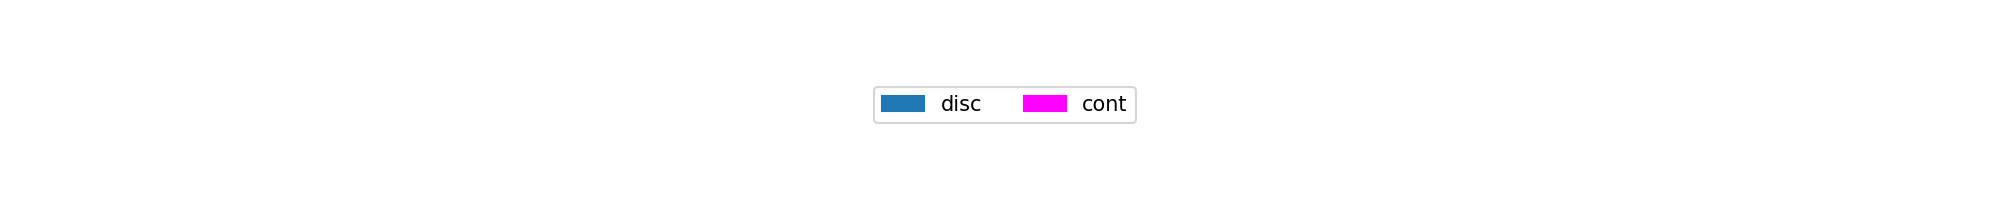

In [50]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [51]:
params = parameter_learning(geo_train, geo_types, bn_geo)

In [52]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [53]:
acc, rmse, real_data, pred_data = calculate_acc(geo_bn, geo_test, columns)

In [54]:
acc

{'Treatment': 0.06}

In [55]:
rmse

{'SproutN': 0.27,
 'BunchN': 0.57,
 'GrapeW': 0.77,
 'WoodW': 0.54,
 'SPAD06': 0.14,
 'NDVI06': 0.14,
 'SPAD08': 0.15,
 'NDVI08': 0.17,
 'Acid': 0.2,
 'Potass': 0.2,
 'Brix': 0.09,
 'pH': 0.05,
 'Anthoc': 0.5,
 'Polyph': 0.34}

In [56]:
for key in acc.keys():
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'D+M','accuracy':acc[key]}, ignore_index=True)
for key in rmse.keys():
    df_result_rmse = df_result_rmse.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'D+M','rmse':rmse[key]}, ignore_index=True)

# Смешанная структура + смешанные параметры

In [57]:
bn_geo = structure_learning(geo_coded, 'evo', 'MI', geo_types)

Cannot add to history: 'str' object has no attribute 'operation_type'
Best metric is -10.16405598034756
Generation num: 0
max_depth: 3, no improvements: 0
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.1 min
Best metric is -11.90271621604929
Generation num: 1
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.2 min
Best metric is -11.90271621604929
Generation num: 2
max_depth: 3, no improvements: 1
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.2 min
Best metric is -11.90271621604929
Generation num: 3
max_depth: 3, no improvements: 2
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.2 min
Best metric is -16.08680164780271
Generation num

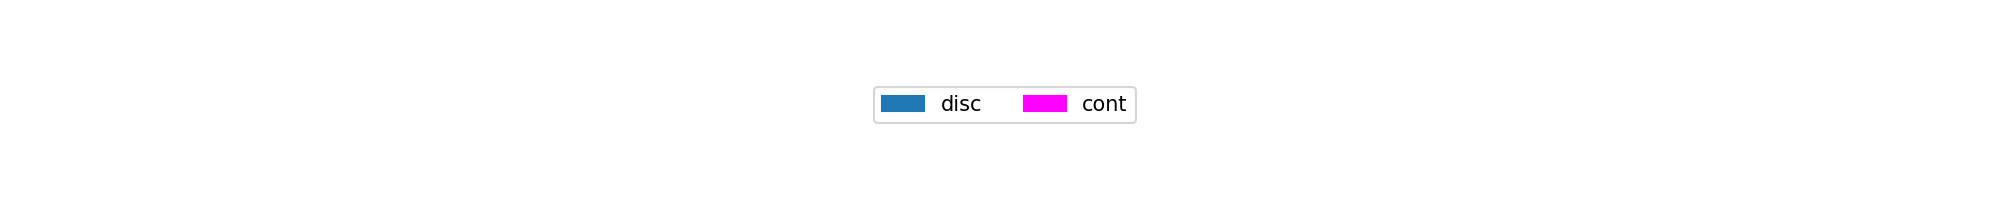

In [58]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [59]:
params = parameter_learning(geo_train, geo_types, bn_geo)

In [60]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [61]:
acc, rmse, real, pred = calculate_acc(geo_bn, geo_test, columns)

In [62]:
acc

{'Treatment': 0.05}

In [63]:
rmse

{'SproutN': 0.27,
 'BunchN': 0.57,
 'GrapeW': 0.7,
 'WoodW': 0.54,
 'SPAD06': 0.13,
 'NDVI06': 0.14,
 'SPAD08': 0.13,
 'NDVI08': 0.17,
 'Acid': 0.2,
 'Potass': 0.2,
 'Brix': 0.11,
 'pH': 0.05,
 'Anthoc': 0.47,
 'Polyph': 0.34}

In [64]:
for key in acc.keys():
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'M+M','accuracy':acc[key]}, ignore_index=True)
for key in rmse.keys():
    df_result_rmse = df_result_rmse.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'M+M','rmse':rmse[key]}, ignore_index=True)

# Дискретная структура + дискретные параметры

In [65]:
geo_new_types = {'Treatment': 'disc',
 'SproutN': 'disc',
 'BunchN': 'disc',
 'GrapeW': 'disc',
 'WoodW': 'disc',
 'SPAD06': 'disc',
 'NDVI06': 'disc',
 'SPAD08': 'disc',
 'NDVI08': 'disc',
 'Acid': 'disc',
 'Potass': 'disc',
 'Brix': 'disc',
 'pH': 'disc',
 'Anthoc': 'disc',
 'Polyph': 'disc'}

In [66]:
bn_geo = structure_learning(geo_discrete, 'evo', 'MI', geo_new_types)

Cannot add to history: 'str' object has no attribute 'operation_type'
Best metric is 19.355200000000004
Generation num: 0
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.1 min
Best metric is 19.353300000000004
Generation num: 1
max_depth: 3, no improvements: 0
Number of mutation attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.1 min
Best metric is 19.351200000000006
Generation num: 2
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.1 min
Best metric is 19.351200000000006
Generation num: 3
max_depth: 3, no improvements: 1
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.2 min
Best metric is 19.351200000000006
Generation num: 4
max_depth: 3, no improvements: 2
Cannot add to history: 'str' object has no attribute 'o

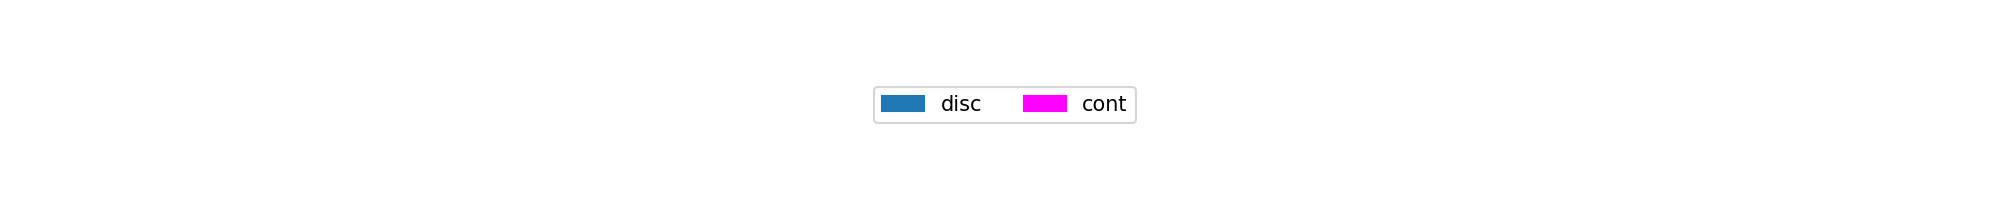

In [67]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [68]:
params = parameter_learning(geo_only_discrete, geo_new_types, bn_geo)

In [69]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [70]:
acc, rmse, real, pred = calculate_acc(geo_bn, test_discrete, columns)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future wil

In [71]:
acc

{'Treatment': 0.09,
 'SproutN': 0.0,
 'BunchN': 0.0,
 'GrapeW': 0.0,
 'WoodW': 0.0,
 'SPAD06': 0.0,
 'NDVI06': 0.0,
 'SPAD08': 0.0,
 'NDVI08': 0.0,
 'Acid': 0.0,
 'Potass': 0.0,
 'Brix': 0.0,
 'pH': 0.0,
 'Anthoc': 0.0,
 'Polyph': 0.0}

In [72]:
for key in colums_for_code:
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'D+D','accuracy':acc[key]}, ignore_index=True)

In [73]:
invers_real = inverse_discretization(pd.DataFrame(np.transpose(real[1:15]), columns=['SproutN', 'BunchN', 'GrapeW', 'WoodW',
       'SPAD06', 'NDVI06', 'SPAD08', 'NDVI08', 'Acid', 'Potass', 'Brix', 'pH',
       'Anthoc', 'Polyph']), ['SproutN', 'BunchN', 'GrapeW', 'WoodW',
       'SPAD06', 'NDVI06', 'SPAD08', 'NDVI08', 'Acid', 'Potass', 'Brix', 'pH',
       'Anthoc', 'Polyph'], discrete_coder)

In [74]:
invers_pred = inverse_discretization(pd.DataFrame(np.transpose(pred[1:15]), columns=['SproutN', 'BunchN', 'GrapeW', 'WoodW',
       'SPAD06', 'NDVI06', 'SPAD08', 'NDVI08', 'Acid', 'Potass', 'Brix', 'pH',
       'Anthoc', 'Polyph']), ['SproutN', 'BunchN', 'GrapeW', 'WoodW',
       'SPAD06', 'NDVI06', 'SPAD08', 'NDVI08', 'Acid', 'Potass', 'Brix', 'pH',
       'Anthoc', 'Polyph'], discrete_coder)

In [75]:
for c in ['SproutN', 'BunchN', 'GrapeW', 'WoodW',
       'SPAD06', 'NDVI06', 'SPAD08', 'NDVI08', 'Acid', 'Potass', 'Brix', 'pH',
       'Anthoc', 'Polyph']:
    m = mean_squared_error(invers_real[c], invers_pred[c], squared=False)
    df_result_rmse = df_result_rmse.append({'Parameter': c, 'Strategy': 'evo', 'Alg':'D+D','rmse':m}, ignore_index=True)

# Смешанная структура + дискретные параметры

In [76]:
bn_geo = structure_learning(geo_coded, 'evo', 'MI', geo_new_types)

Cannot add to history: 'str' object has no attribute 'operation_type'
Best metric is -12.934949184851053
Generation num: 0
max_depth: 3, no improvements: 0
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Number of crossover attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.1 min
Best metric is -12.934949184851053
Generation num: 1
max_depth: 3, no improvements: 1
Number of mutation attempts exceeded. Please check composer requirements for correctness.
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.2 min
Best metric is -13.969958772276007
Generation num: 2
max_depth: 3, no improvements: 0
Cannot add to history: 'str' object has no attribute 'operation_type'
spent time: 0.3 min
Best metric is -13.969958772276007
Generation num: 3
max_depth: 3, no improvements: 1
Cannot add to history: 'str' object has no a

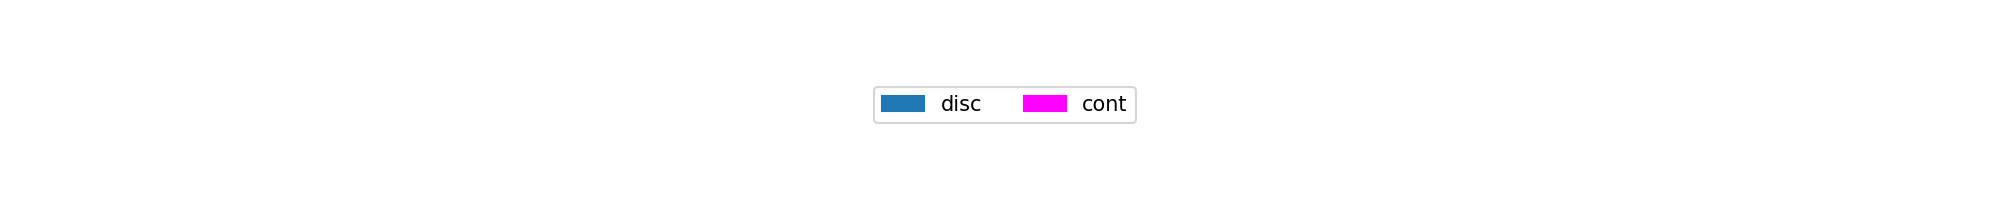

In [77]:
draw_BN(bn_geo, geo_types, 'geo_net')

In [78]:
params = parameter_learning(geo_only_discrete, geo_new_types, bn_geo)

In [79]:
save_structure(bn_geo, 'geo_net')
skel = read_structure('geo_net')
save_params(params, 'geo_net_param')
params = read_params('geo_net_param')
geo_bn = HyBayesianNetwork(skel, params)

In [80]:
acc, rmse, real, pred = calculate_acc(geo_bn, test_discrete, columns)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:208: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future wil

In [81]:
acc

{'Treatment': 0.02,
 'SproutN': 0.0,
 'BunchN': 0.0,
 'GrapeW': 0.0,
 'WoodW': 0.0,
 'SPAD06': 0.0,
 'NDVI06': 0.0,
 'SPAD08': 0.0,
 'NDVI08': 0.0,
 'Acid': 0.0,
 'Potass': 0.0,
 'Brix': 0.0,
 'pH': 0.0,
 'Anthoc': 0.0,
 'Polyph': 0.0}

In [82]:
for key in colums_for_code:
    df_result_accuracy = df_result_accuracy.append({'Parameter': key, 'Strategy': 'evo', 'Alg':'M+D','accuracy':acc[key]}, ignore_index=True)

In [83]:
invers_real = inverse_discretization(pd.DataFrame(np.transpose(real[1:15]), columns=['SproutN', 'BunchN', 'GrapeW', 'WoodW',
       'SPAD06', 'NDVI06', 'SPAD08', 'NDVI08', 'Acid', 'Potass', 'Brix', 'pH',
       'Anthoc', 'Polyph']), ['SproutN', 'BunchN', 'GrapeW', 'WoodW',
       'SPAD06', 'NDVI06', 'SPAD08', 'NDVI08', 'Acid', 'Potass', 'Brix', 'pH',
       'Anthoc', 'Polyph'], discrete_coder)

In [84]:
invers_pred = inverse_discretization(pd.DataFrame(np.transpose(pred[1:15]), columns=['SproutN', 'BunchN', 'GrapeW', 'WoodW',
       'SPAD06', 'NDVI06', 'SPAD08', 'NDVI08', 'Acid', 'Potass', 'Brix', 'pH',
       'Anthoc', 'Polyph']), ['SproutN', 'BunchN', 'GrapeW', 'WoodW',
       'SPAD06', 'NDVI06', 'SPAD08', 'NDVI08', 'Acid', 'Potass', 'Brix', 'pH',
       'Anthoc', 'Polyph'], discrete_coder)

In [85]:
for c in ['SproutN', 'BunchN', 'GrapeW', 'WoodW',
       'SPAD06', 'NDVI06', 'SPAD08', 'NDVI08', 'Acid', 'Potass', 'Brix', 'pH',
       'Anthoc', 'Polyph']:
    m = mean_squared_error(invers_real[c], invers_pred[c], squared=False)
    df_result_rmse = df_result_rmse.append({'Parameter': c, 'Strategy': 'evo', 'Alg':'M+D','rmse':m}, ignore_index=True)

In [86]:
df_result_accuracy.to_csv('sangiovese_results_disc.csv', index=False)
df_result_rmse.to_csv('sangiovese_results_cont.csv', index=False)